# STATE SPACE MODEL

## DATA PREPROCESSING

###  install packages on the python environment, if not yet present

In [462]:
# %pip install -I jinja2==3.0.3 --user
# %pip install scikit-learn==1.1.3
# %pip install statsmodels
# %pip install particles
# %pip install pandas
# %pip install matplotlib
# %conda install -c "conda-forge/label/broken" nbconvert-webpdf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline
import particles  #sampling 
from particles import state_space_models as ssm  #defining state space models and feynman Kac
from particles import distributions as dists  #distributions definitions
from particles.collectors import Moments  #moment definitions


### ETS steps on UNSW_NB15 set with feature reduction

#### Import Data

read the UNSW NB15 dataset, this seems a 'better' data source where the packets are 'numbered" and sequential (necessary to go along with Markov properties)

In [463]:
# import the dataset as a pandas dataframe
train_data_url = "https://raw.githubusercontent.com/stijnhuysman/DissertationData/main/UNSW_NB15_training-set.csv"
dftot = pd.read_csv(train_data_url)
print(dftot.shape)
# dftot.iloc[243:,:]
dftot.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


#### SPLIT into GOOD AND ANOMALY 

split in two datasets = normal(37000) and anomaly(45332) each 45 features

In [464]:
dftot
normal = dftot[dftot.label.eq(0)]
anomaly = dftot[dftot.label.eq(1)]
print(type(dftot), dftot.shape, normal.shape, anomaly.shape)
dataset_total = dftot.to_numpy()
type(dataset_total)

print(normal.shape, anomaly.shape)

<class 'pandas.core.frame.DataFrame'> (82332, 45) (37000, 45) (45332, 45)
(37000, 45) (45332, 45)


#### Feature selection on GOOD and ANOMALY

functions for later use : variance treshold and VIF 

In [465]:
# FUNCTION VAR SELECTION
def variance_threshold_selector(data, threshold=0.75):
    selector = VarianceThreshold(threshold*(1-threshold))
    selector.fit_transform(data)
    return data[data.columns[selector.get_support(indices=True)]]


from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)



create dummy variables on the categoricals for each dataset and apply the feature reduction
Here, the features with VIF under 5 are kept

In [466]:
# NORMAL FEATURE SELECTION
####################
# FEATURES DATASET #
####################
# creating dummy variables on the categorical values
normal = pd.get_dummies(data=normal.iloc[:,:(-2)] ,  #exclude the last two columns
                        drop_first=True,
                        columns=['proto', 'service', 'state']
                         , dtype=np.uint0)

print(normal.shape)

#reduced dataframe where 80 %  variance is explained
normal_selected = variance_threshold_selector(normal)
print("selected normal ", normal_selected.shape)



anomaly = pd.get_dummies(data=anomaly.iloc[:,:(-2)] ,  #exclude the last two columns
                        drop_first=True,
                        columns=['proto', 'service', 'state']
                         , dtype=np.uint0)

print(anomaly.shape)
#reduced dataframe where 80 %  variance is explained
anomaly_selected = variance_threshold_selector(anomaly)
print("selected anomaly ",anomaly_selected.shape)




#####################################
# MULTICOLLINEARITY REDUCTION       #
# ONLY THE COMMON FEATURES ARE KEPT #
#####################################

VIF_table_normal = calc_vif(normal_selected).sort_values(by=['VIF'], ascending=False)
VIF_table_anomaly = calc_vif(anomaly_selected).sort_values(by=['VIF'], ascending=False)
# VIF_table_normal_trans = calc_vif(normal_trans_selected).sort_values(by=['VIF'], ascending=False)

VIF_select_normal = VIF_table_normal[(VIF_table_normal['VIF'] <= 5)]
VIF_select_anomaly = VIF_table_anomaly[(VIF_table_anomaly['VIF'] <= 5)]
# VIF_select_normal_trans = VIF_table_normal_trans[(VIF_table_normal_trans['VIF'] <= 5)]

# assuming the common column name is "
VIF_selected = pd.merge(VIF_select_normal, VIF_select_anomaly, on="variables", how="inner")

# VIFS = VIF_selected.sort_values('VIF_x')[:3]

VIFS = VIF_selected.sort_values('VIF_x')

selection = VIFS.iloc[:,0].values.tolist()
# selection_normal_transformed = VIF_select_normal_trans[:,0].values.tolist()

normal_selected = normal_selected[selection]
anomaly_selected = anomaly_selected[selection]
# normal_trans_selected =normal_trans_selected[selection]

print(normal_selected.shape)
print(anomaly_selected.shape)
print('')
print(len(normal_selected.columns)," variables selected, based on mutual <5 VIF for further use:")
print(normal_selected.columns.tolist())
print("")
print("amount of features in the training dataset after multicollinearity reductions: " ,len(normal_selected.columns))
print("amount of observations in the normal  training dataset before subsetting: " ,len(normal_selected.index))
print("amount of observations in the normal  training dataset before subsetting: " ,len(anomaly_selected.index))
NumberVars = len(normal_selected.columns)
VIF_selected.sort_values('VIF_x')
normal_selected.shape
VIFS
# VIF_table_normal
NumberVars


(37000, 56)
selected normal  (37000, 33)
(45332, 185)
selected anomaly  (45332, 38)
(37000, 10)
(45332, 10)

10  variables selected, based on mutual <5 VIF for further use:
['dur', 'djit', 'response_body_len', 'sinpkt', 'sload', 'rate', 'dload', 'dtcpb', 'stcpb', 'smean']

amount of features in the training dataset after multicollinearity reductions:  10
amount of observations in the normal  training dataset before subsetting:  37000
amount of observations in the normal  training dataset before subsetting:  45332


10

In [467]:
# create a DataFrame with two columns
test = ['dur', 'djit', 'response_body_len', 'sinpkt', 'sload', 'rate', 'dload', 'dtcpb', 'stcpb', 'smean']
# create a DataFrame with two columns
df = pd.DataFrame({'selected features: ': test})

# remove the index column from the display
df2 = df.set_index('selected features: ', drop=True)
df3 = df2.transpose()
styled_df = df3.style.set_properties(**{'text-align': 'left'})

# display the styled DataFrame
display(styled_df)

selected features:,dur,djit,response_body_len,sinpkt,sload,rate,dload,dtcpb,stcpb,smean


#### Standardize selected features 


In [468]:
NORMAL = normal_selected.to_numpy()
ANOMALY = anomaly_selected.to_numpy()
# NORMAL

## HMM MODEL WITH MVNORMAL and FK objects

### HMM preparing

### STATESPACE MODEL CLASS

### CLASS DEFINITION  (GENERAL DEFINITION)

GENERAL STATE SPACE MODEL with  
$P(X_0) = MvNormal(0, 1)$  
as the prior distribution for the hidden state


$P(X_t|X_{t-1}) = MvNormal(X_{t-1}, \sigma_x^{2})$  
as the Markov Kernel to extend from state $X_{t-1}$ to state $X_t $ 


$P(Y_t|X_t) = MvNormal(X_t,\Sigma)$   
as the observations, being a function of the state of the moment with noise   

THE GOAL TO ACHIEVE IS TO ESTIMATE WITH THE PARTICLE FILTER :  
**$P(X_t|Y_{0:t})$ or the posterior distribution of the states, given the observations, from $time_0$ to $time_t$**


**$P_{NORMAL}(X_t|Y^{normal}_{0:t})$**  and 
**$P_{ANOMALY}(X_t|Y^{anomaly}_{0:t})$**




THIS IS THE KEY STATESPACEMODEL THAT ENCOMPASSESS THE STATE AND OBSERVATIONS RELATIONS  
**No dynamics are known from the hidden spaces**  
only normal noise is added to the model


In [469]:
# The hidden markov model defines multivariate states that proceed  with 
# RANDOM noise according to a multivariate Normal Distribution of the preceding state and noise

#THE MEASUREMENTS ARE SIMULATED from their corresponding State and noise.

class MULTIVARIATE(ssm.StateSpaceModel):
    
    default_params = {'sigmaX':1, 'sigmaY':1, 'rho': 1 , 'nvars' : 1, 'covY': np.eye(1), 'start' : np.zeros(1)}
    def PX0(self):  # The law of X_0
           return dists.MvNormal(loc=self.start, 
#                                  scale=self.sigmaX, 
                                 scale = 1,
                                 cov=(np.eye(self.nvars))*1/(1-self.rho**2))
        
    def PX(self, t, xp):  # The law of X_t conditional on X_{t-1}
        return dists.MvNormal(loc=(self.start + self.rho*(xp-self.start)),
                              scale=self.sigmaX,
                              cov=np.eye(self.nvars))
    
    def PY(self, t, xp, x):  # the law of Y_t given X_t and X_{t-1}
        return dists.MvNormal(loc=0, 
#                               scale=self.sigmaY,
#                             cov= self.covY
                              cov = self.covY)

# N_SSM1 = MULTIVARIATE(rho = 0.8, covY=np.eye(NumberVars), nvars= NumberVars, start = mean_NORMAL)
# N_SSM1

In [470]:
import particles 
from particles import state_space_models as ssm
# The hidden markov model defines multivariate states that proceed  with 
# RANDOM noise according to a multivariate Normal Distribution of the preceding state and noise

#THE MEASUREMENTS ARE SIMULATED from their corresponding State and noise.

class MULTIVARIATE(ssm.StateSpaceModel):
    
    default_params = {'sigmaX':1, 'sigmaY':1, 'rho': 1 , 'nvars' : 1, 'covY': np.eye(1), 'start' : np.zeros(1)}
    def PX0(self):  # The law of X_0
           return dists.MvNormal(loc=self.start, 
                                 scale=self.sigmaX, 
                                 cov=np.eye(self.nvars))
        
    def PX(self, t, xp):  # The law of X_t conditional on X_{t-1}
        return dists.MvNormal(loc=(self.rho* xp),
                              scale=self.sigmaX,
                              cov=np.eye(self.nvars))
    
    def PY(self, t, xp, x):  # the law of Y_t given X_t and X_{t-1}
        return dists.MvNormal(loc=x, 
                              scale=self.sigmaY,
                            cov= self.covY)



In [471]:
import particles 
from particles import state_space_models as ssm
# The hidden markov model defines multivariate states that proceed  with 
# RANDOM noise according to a multivariate Normal Distribution of the preceding state and noise

#THE MEASUREMENTS ARE SIMULATED from their corresponding State and noise.

class MULTIVARIATE(ssm.StateSpaceModel):
    
    default_params = { 'rho': 1 , 'nvars' : 1,  'start' : np.zeros(1)}
    
    def PX0(self):  # The law of X_0   MVN around start
        return dists.MvNormal(loc=self.start , 
                              cov=np.eye(self.nvars)/np.sqrt(1-self.rho**2))
        
#     HERE IT IS DEFINED AS THE DEFUBED BY A RANDOM WALK WITH DRIFT 
    def PX(self, t, xp):  # The law of X_t conditional on X_{t-1}
        return dists.MvNormal(loc=self.start +self.rho*(xp - self.start),
                              cov=np.eye(self.nvars))
    
    def PY(self, t, xp, x):  # the law of Y_t given X_t and X_{t-1}
        return dists.MvNormal(loc=x,
                              scale = np.abs(x),
                              cov=np.eye(self.nvars)
                             )



#### SSM with uniform cov matrix 

the state space model is definied by the class and some parameters choosen

her, we calculate the start value as the mean of the first 500 obs

In [472]:
NORMAL

array([[1.10e-05, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 2.48e+02],
       [8.00e-06, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 8.81e+02],
       [5.00e-06, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 5.34e+02],
       ...,
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 4.60e+01],
       [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 4.60e+01],
       [9.00e-06, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 5.20e+01]])

In [473]:
NORMAL.shape
mean_NORMAL = np.mean(NORMAL[:500], axis=0)
mean_NORMAL
# mean_NORMAL_t = np.mean(NORMAL_t[:500], axis=0)

mean_ANOMALY = np.mean(ANOMALY[:500], axis=0)
mean_ANOMALY
# mean_ANOMALY_t = np.mean(ANOMALY_t[:500], axis=0)


array([1.48744579e+00, 6.05074323e+02, 2.87947400e+03, 1.18422128e+02,
       7.65103518e+07, 7.31334283e+04, 4.87843462e+04, 1.17328625e+09,
       1.16710185e+09, 1.64072000e+02])

In [474]:
N_SSM1 = MULTIVARIATE(rho = 0.9, covY=np.eye(NumberVars), nvars= NumberVars, start = mean_NORMAL)
N_SSM2 = MULTIVARIATE(rho = 0.8, covY=np.eye(NumberVars), nvars= NumberVars,start = mean_NORMAL)
N_SSM3 = MULTIVARIATE(rho = 0.7, covY=np.eye(NumberVars), nvars= NumberVars, start = mean_NORMAL)

A_SSM1 = MULTIVARIATE(rho = 0.9, covY= np.eye(NumberVars), nvars= NumberVars, start = mean_ANOMALY)
A_SSM2 = MULTIVARIATE(rho = 0.8, covY=np.eye(NumberVars), nvars= NumberVars,start = mean_ANOMALY)
A_SSM3 = MULTIVARIATE(rho = 0.7, covY= np.eye(NumberVars), nvars= NumberVars, start = mean_ANOMALY)



### Define Feynman Kac models = statespacemodel and data

Using the FK formalism, we define the  'framework' to generate a Bootstrap model,   
combining the SSM and data at every point int time  

In [475]:
from particles import state_space_models as ssm

#NORMALS
N_fk1 =ssm.Bootstrap(ssm=N_SSM1, data=NORMAL.tolist())  #identity cov 100 %
N_fk2 =ssm.Bootstrap(ssm=N_SSM2, data=NORMAL.tolist())  #cov_NORMAL
N_fk3 =ssm.Bootstrap(ssm=N_SSM3, data=NORMAL.tolist())  #identity cov 100 %

A_fk1 =ssm.Bootstrap(ssm=A_SSM1, data=ANOMALY.tolist())  #identity cov 100 %
A_fk2 =ssm.Bootstrap(ssm=A_SSM2, data=ANOMALY.tolist())  #cov_NORMAL
A_fk3 =ssm.Bootstrap(ssm=A_SSM3, data=ANOMALY.tolist())  #identity cov 100 %

In [476]:
ANOMALY[0]

array([9.2198700e-01, 0.0000000e+00, 0.0000000e+00, 4.8525633e+01,
       1.0551125e+04, 2.0607666e+01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 6.4000000e+01])

## RUN SAMPLERS

### multiple SAMPLER

Underneath is the sampler, using multiple FK models embedded, and running multiple times with 3 amount of particles

for this case ;;;

### RUN THE SAMPLER ! 5 minutes

In [477]:
import time

#NETWORK DATA WITH NORMAL CHARACTER
start = time.time()
RESULT_NORMAL = particles.multiSMC(fk=[ N_fk1, N_fk2, N_fk3], 
                            nruns=1, 
                            N=[1000], 
                            nprocs=0,store_history = False,ESSrmin = 0.5,collect=[Moments],resampling = ['systematic'])

end = time.time()
print("NORMAL : The time of execution of above program with ", len(RESULT_NORMAL), " combinatons took :",
      (end-start)/60 , "min")


NORMAL : The time of execution of above program with  3  combinatons took : 1.4998351057370505 min


In [478]:
#NETWORK DATA WITH ANOMALY CHARACTER
start = time.time()
RESULT_ANOMALY = particles.multiSMC(fk=[ A_fk1, A_fk2, A_fk3], 
                            nruns=1, 
                            N=[1000], 
                            nprocs=0,store_history = False,ESSrmin = 0.5,collect=[Moments],resampling = ['systematic'])
                            


end = time.time()
print("ANOMALY : The time of execution of above program with ", len(RESULT_ANOMALY), " combinatons took :",
      (end-start)/60 , "min")


ANOMALY : The time of execution of above program with  3  combinatons took : 1.6017837524414062 min


## RESULTS

### NORMAL NETWORK PACKETS DISTRIBUTION

FIRST CONTINUE ON THE NORMAL, the ANOMALY WILL BE SIMILAR

In [479]:
#NORMAL RESULTS
for i in range(len(RESULT_NORMAL)):
    print(
          RESULT_NORMAL[i] , 'model run ', [RESULT_NORMAL[i]['fk'].ssm.nvars,
                         RESULT_NORMAL[i]['fk'].ssm.rho,
#                          RESULT_NORMAL[i]['fk'].ssm.covY,
                         ],
                         
                         " and run" , RESULT_NORMAL[i]['run'] , 
          " with ",  RESULT_NORMAL[i]['N'], "particles took ", 
    RESULT_NORMAL[i]['output'].cpu_time, " seconds" , RESULT_NORMAL[i]['output'])
    print("")

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B344A54C0>, 'N': 1000, 'resampling': 'systematic', 'seed': 95718156, 'output': <particles.core.SMC object at 0x0000018B3AA38340>} model run  [10, 0.9]  and run 0  with  1000 particles took  80.8126555  seconds t=37000: resample:True, ESS (end of iter)=5.27

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B34A9A0D0>, 'N': 1000, 'resampling': 'systematic', 'seed': 2757966872, 'output': <particles.core.SMC object at 0x0000018B3AA38730>} model run  [10, 0.8]  and run 0  with  1000 particles took  80.2542861  seconds t=37000: resample:True, ESS (end of iter)=18.88

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B3DF78BE0>, 'N': 1000, 'resampling': 'systematic', 'seed': 3463001133, 'output': <particles.core.SMC object at 0x0000018B43079460>} model run  [10, 0.7]  and run 0  with  1000 particles took  79.9332408  seconds t=37000: resample:True, ESS (end of iter)

In [480]:
N_mom_1 = RESULT_NORMAL[0]['output'].summaries.moments
N_mom_2 = RESULT_NORMAL[1]['output'].summaries.moments
N_mom_3 = RESULT_NORMAL[2]['output'].summaries.moments
len(N_mom_3)
N_mom_1[600]

{'mean': array([1.26922994e-01, 6.09768163e+02, 1.76731057e-01, 1.74467515e+03,
        6.75397619e+07, 2.01743750e+04, 1.87905557e+06, 1.03720138e+09,
        1.12778328e+09, 1.35754254e+02]),
 'var': array([ 2.58220857e-01,  1.40533228e+00,  2.95603224e-01,  1.16484702e+00,
        -1.00000000e+00,  2.33828288e+00,  1.01269531e+00,  5.12000000e+02,
         0.00000000e+00,  1.52146108e+00])}

In [481]:
N_mean_vector1 = [N_mom_1[i]['mean'].tolist() for i in range(len(N_mom_1))]
N_var_vector1 = [N_mom_1[i]['var'].tolist() for i in range(len(N_mom_1))]

N_mean_list1 = [np.array([sub[i] for sub in N_mean_vector1]) for i in range(len(N_mean_vector1[0]))]
N_var_list1 = [np.array([sub[i] for sub in N_var_vector1]) for i in range(len(N_var_vector1[0]))]




N_mean_vector2 = [N_mom_2[i]['mean'].tolist() for i in range(len(N_mom_2))]
N_var_vector2 = [N_mom_2[i]['var'].tolist() for i in range(len(N_mom_2))]

N_mean_list2 = [np.array([sub[i] for sub in N_mean_vector2]) for i in range(len(N_mean_vector2[0]))]
N_var_list2 = [np.array([sub[i] for sub in N_var_vector2]) for i in range(len(N_var_vector2[0]))]




N_mean_vector3 = [N_mom_3[i]['mean'].tolist() for i in range(len(N_mom_3))]
N_var_vector3 = [N_mom_3[i]['var'].tolist() for i in range(len(N_mom_3))]


N_mean_list3 = [np.array([sub[i] for sub in N_mean_vector3]) for i in range(len(N_mean_vector3[0]))]
N_var_list3 = [np.array([sub[i] for sub in N_var_vector3]) for i in range(len(N_var_vector3[0]))]

N_mean_vector1[3880]
N_mean_list1   #list with 10 arrays, one for each mean-
N_mean_list3[2][10000]

10.562065757137729

In [482]:
%%time
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Listing the estimates per feature (beta, var, under , upper), ready to plot
import numpy as np
N_amountofmeans = len(N_mean_list1)


for j in range(N_amountofmeans):
    globals()[f"N_mean1_{j}"] = N_mean_list1[j]
    globals()[f"N_var1_{j}"] = N_var_list1[j]
    globals()[f"N_under1_{j}"] = globals()[f"N_mean1_{j}"] - 1.96*np.sqrt(globals()[f"N_var1_{j}"])
    globals()[f"N_upper1_{j}"] = globals()[f"N_mean1_{j}"] + 1.96*np.sqrt(globals()[f"N_var1_{j}"])
    
    globals()[f"N_mean2_{j}"] = N_mean_list2[j]
    globals()[f"N_var2_{j}"] = N_var_list2[j]
    globals()[f"N_under2_{j}"] = globals()[f"N_mean2_{j}"] - 1.96*np.sqrt(globals()[f"N_var2_{j}"])
    globals()[f"N_upper2_{j}"] = globals()[f"N_mean2_{j}"] + 1.96*np.sqrt(globals()[f"N_var2_{j}"])
    
    
    globals()[f"N_mean3_{j}"] = N_mean_list3[j]
    globals()[f"N_var3_{j}"] = N_var_list3[j]
    globals()[f"N_under3_{j}"] = globals()[f"N_mean3_{j}"] - 1.96*np.sqrt(globals()[f"N_var3_{j}"])
    globals()[f"N_upper3_{j}"] = globals()[f"N_mean3_{j}"] + 1.96*np.sqrt(globals()[f"N_var3_{j}"])
    
print(N_amountofmeans)
N_mean3_0.shape

10
CPU times: total: 15.6 ms
Wall time: 20 ms


(37000,)

In [483]:
t = np.arange(len(N_mom_3))
t
N_mean1_0.shape
len(N_mean_list1[0])

37000

In [484]:
p =3000
print(N_mean1_1[p],N_mean1_2[p])#,N_mean1_3[p],N_mean1_4[p],N_mean1_5[p],N_mean1_6[p])#,mean7_0[p],mean8_0[p],mean9_0[p])

607.7223265644941 0.3305631780224814


The selected columns

In [485]:
features = normal_selected.columns.tolist()
features

['dur',
 'djit',
 'response_body_len',
 'sinpkt',
 'sload',
 'rate',
 'dload',
 'dtcpb',
 'stcpb',
 'smean']

In [486]:
%matplotlib inline

In [487]:
N_amountofmeans

10

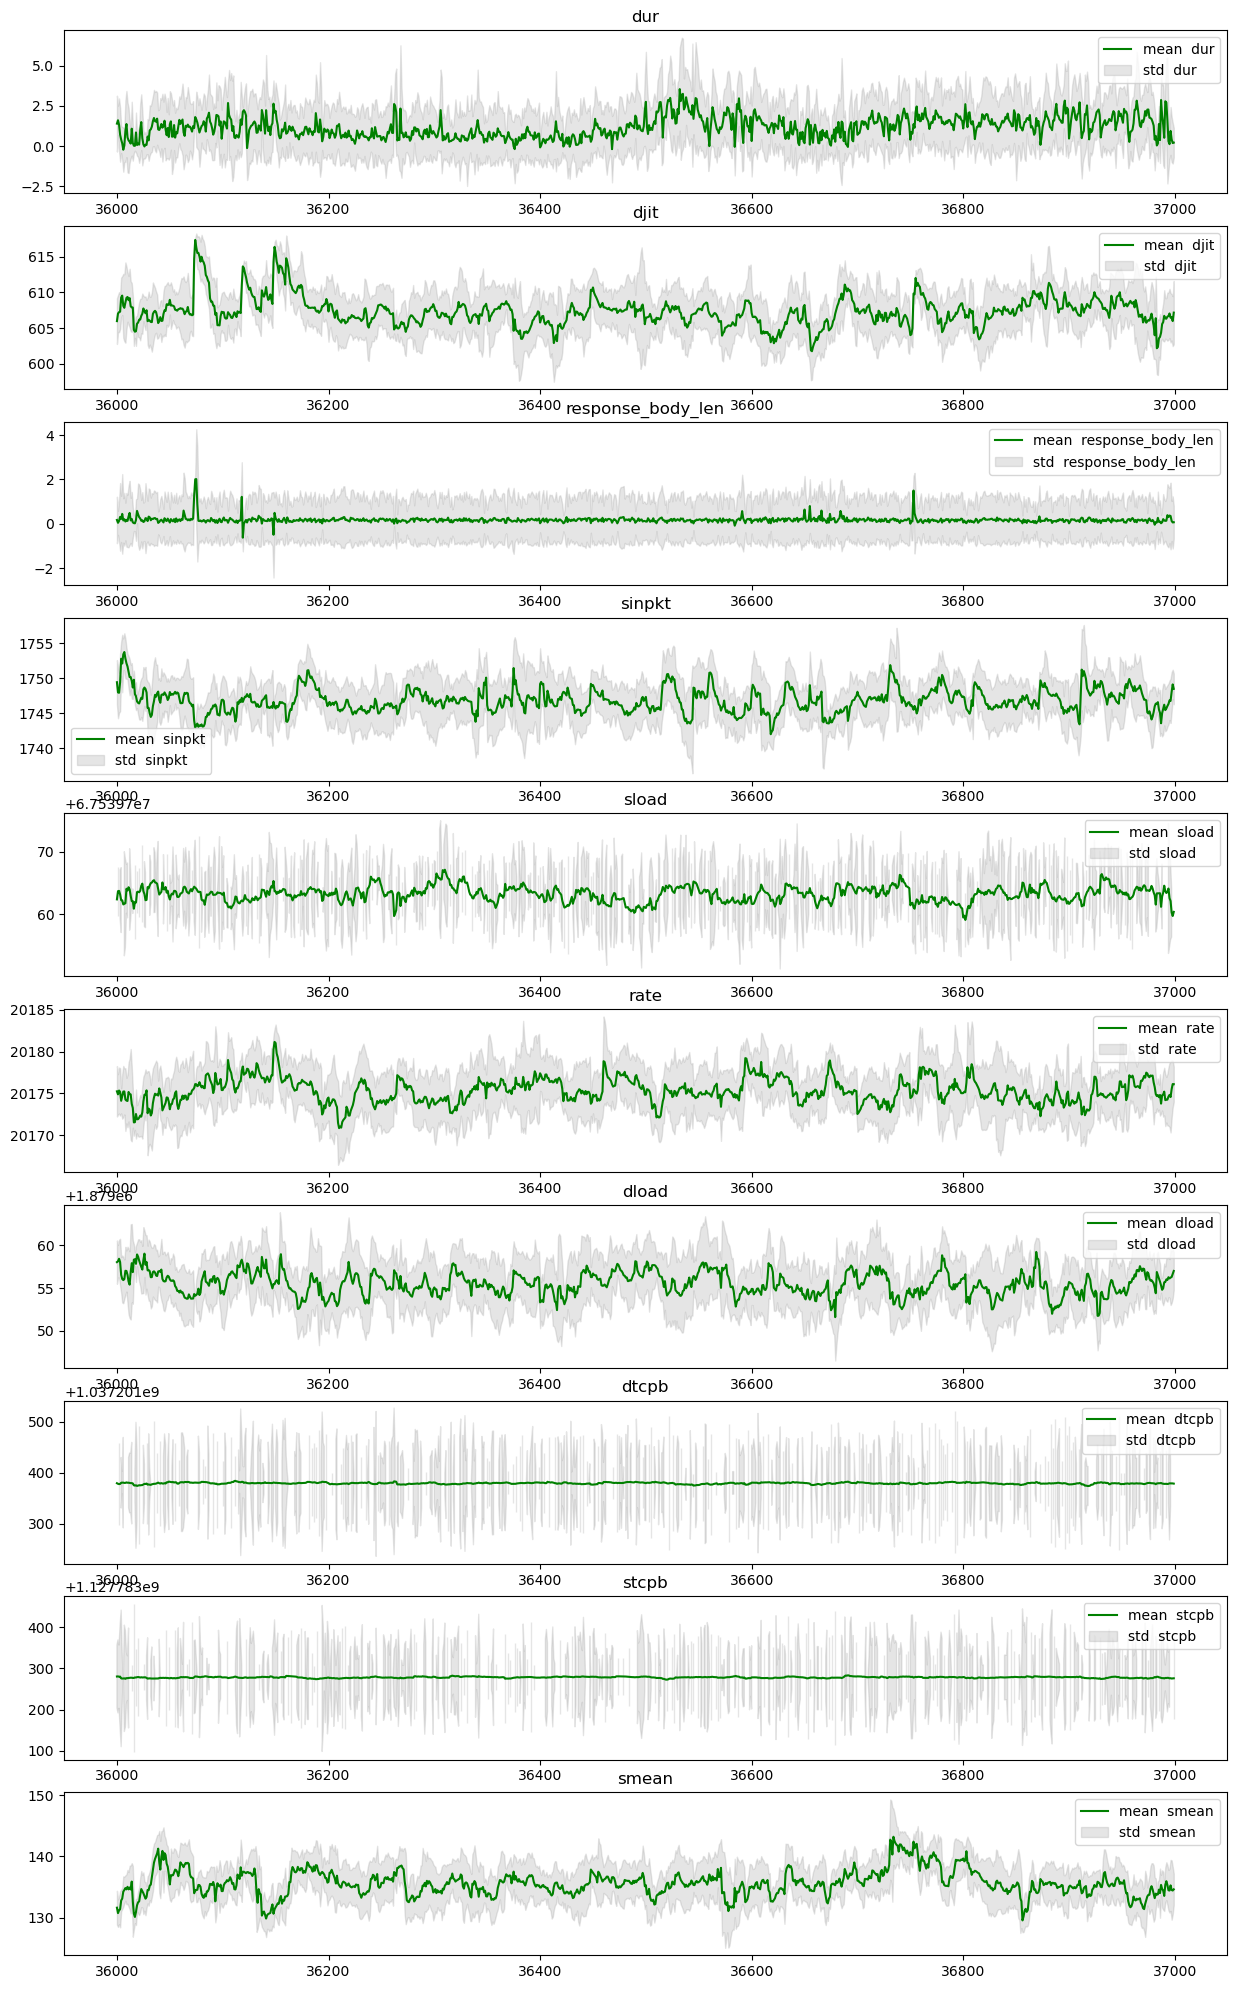

In [488]:
import numpy as np
import matplotlib.pyplot as plt
f = int(-1000)
# Create a 5x2 grid of subplots
fig, axs = plt.subplots(N_amountofmeans, 1, figsize=(15, 25))
# Plot each of the 10 plots

k = 0
for i in range(N_amountofmeans):
        
        
        
# Plot the mean line and shaded region between upper and under lines
        axs[i].plot(t[f:], globals()[f"N_mean1_{k}"][f:], label=('mean  ' + features[k]), color='green')
        axs[i].fill_between(t[f:], globals()[f"N_under1_{k}"][f:], globals()[f"N_upper1_{k}"][f:], alpha=0.2, label=('std  ' + features[k]), color='gray')

#         axs[i].plot(t[f:], globals()[f"N_mean2_{k}"][f:], label=('mean  ' + features[k]), color='blue')
#         axs[i].fill_between(t[f:], globals()[f"N_under2_{k}"][f:], globals()[f"N_upper2_{k}"][f:], alpha=0.2, label=('std  ' + features[k]), color='blue')

#         axs[i].plot(t[f:], globals()[f"N_mean3_{k}"][f:], label=('mean  ' + features[k]), color='black')
#         axs[i].fill_between(t[f:], globals()[f"N_under3_{k}"][f:], globals()[f"N_upper3_{k}"][f:], alpha=0.2, label=('std  ' + features[k]), color='blue')

        
        
        # Set the title for the plot
        # axs[i].set_title(f'mean{k}')
        axs[i].set_title(features[k])

        
        # Set the legend for the plot
        axs[i].legend()
        
        
        k+=1

        
       
        
plt.show()
        

ONLY 2 features highlighted

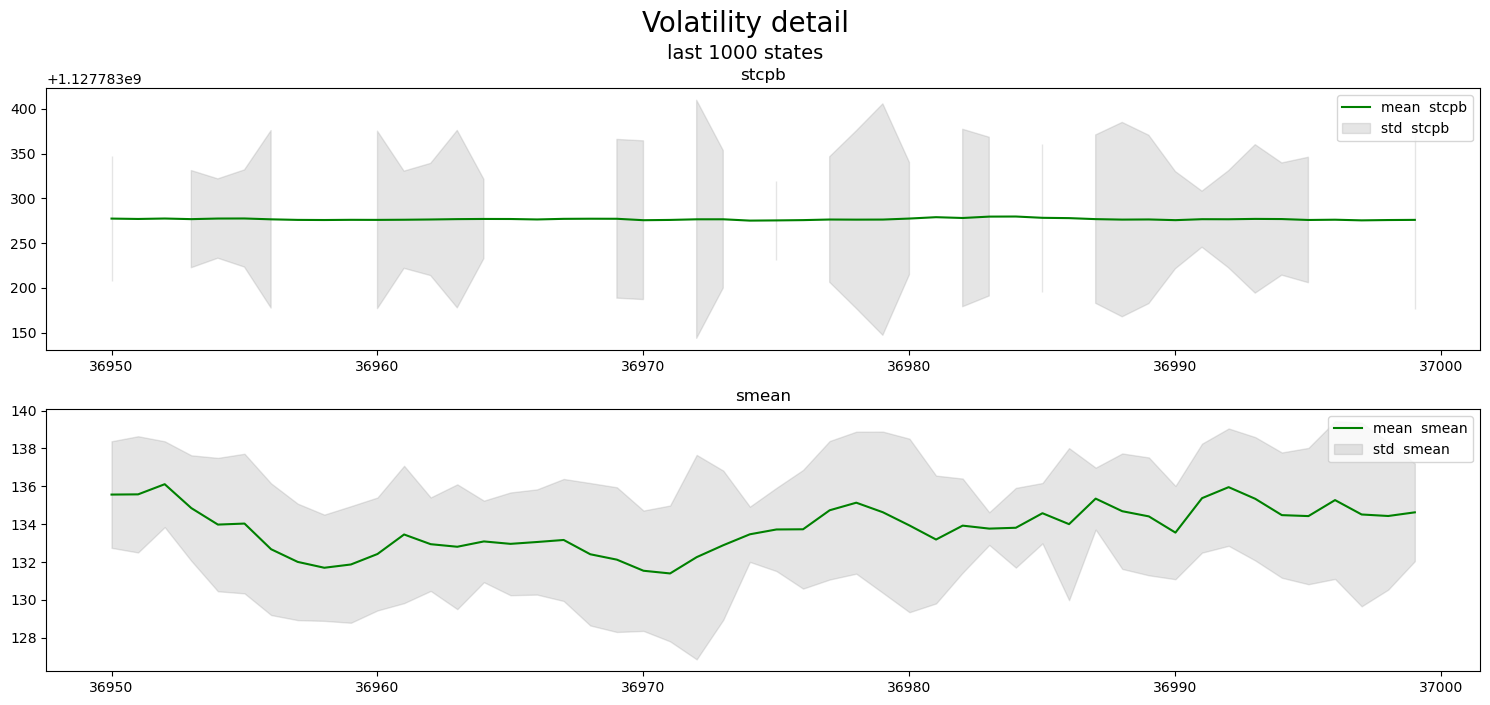

In [489]:
import numpy as np
import matplotlib.pyplot as plt
f = int(-50)
# Create a 5x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
fig.suptitle('Volatility detail', fontsize=20, y=1)
plt.figtext(0.5, 0.93, 'last 1000 states', fontsize=14, ha='center')
r = 0
linewidth = 4
ft = 50
# Plot each of the 10 plots
        
        
# Plot the mean line and shaded region between upper and under lines
axs[0].plot(t[f:], globals()[f"N_mean1_{8}"][f:], label=('mean  ' + features[8]), color='green')
axs[0].fill_between(t[f:], globals()[f"N_under1_{8}"][f:], globals()[f"N_upper1_{8}"][f:], alpha=0.2, label=('std  ' + features[8]), color='gray')
axs[0].legend()
axs[0].set_title(features[8], fontweight = ft)

axs[1].plot(t[f:], globals()[f"N_mean1_{9}"][f:], label=('mean  ' + features[9]), color='green')
axs[1].fill_between(t[f:], globals()[f"N_under1_{9}"][f:], globals()[f"N_upper1_{9}"][f:], alpha=0.2, label=('std  ' + features[9]), color='gray')
axs[1].legend()
axs[1].set_title(features[9], fontweight = ft)
fig.tight_layout()       
plt.savefig('volatility detail2', dpi = 300)       
        
plt.show()
        

### ANOMALY NETWORK PACKETS DISTRIBUTION

the ANOMALY WILL BE SIMILAR

In [490]:
#ANOMALY RESULTS

for i in range(len(RESULT_ANOMALY))[:]:
    print(
          RESULT_ANOMALY[i] , 'model run ', [RESULT_ANOMALY[i]['fk'].ssm.nvars,
                         RESULT_ANOMALY[i]['fk'].ssm.rho,
#                          RESULT_NORMAL[i]['fk'].ssm.covY,
                         ],
                         
                         " and run" , RESULT_ANOMALY[i]['run'] , 
          " with ",  RESULT_ANOMALY[i]['N'], "particles took ", 
    RESULT_ANOMALY[i]['output'].cpu_time, " seconds" , RESULT_ANOMALY[i]['output'])
    print("")

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B34A9A4F0>, 'N': 1000, 'resampling': 'systematic', 'seed': 242425738, 'output': <particles.core.SMC object at 0x0000018B34B1AE80>} model run  [10, 0.9]  and run 0  with  1000 particles took  91.4833468  seconds t=45332: resample:False, ESS (end of iter)=139.83

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B3AA43B80>, 'N': 1000, 'resampling': 'systematic', 'seed': 2413606568, 'output': <particles.core.SMC object at 0x0000018B34B1AB20>} model run  [10, 0.8]  and run 0  with  1000 particles took  88.56073159999998  seconds t=45332: resample:False, ESS (end of iter)=160.00

{'run': 0, 'fk': <particles.state_space_models.Bootstrap object at 0x0000018B3AA43160>, 'N': 1000, 'resampling': 'systematic', 'seed': 4127572848, 'output': <particles.core.SMC object at 0x0000018B34B1A8B0>} model run  [10, 0.7]  and run 0  with  1000 particles took  88.13542899999999  seconds t=45332: resample:Fal

In [491]:
A_mom_1 = RESULT_ANOMALY[0]['output'].summaries.moments

A_mom_2 = RESULT_ANOMALY[1]['output'].summaries.moments
A_mom_3 = RESULT_ANOMALY[2]['output'].summaries.moments
len(A_mom_2)


45332

In [492]:
A_mean_vector1 = [A_mom_1[i]['mean'].tolist() for i in range(len(A_mom_1))]
A_var_vector1 = [A_mom_1[i]['var'].tolist() for i in range(len(A_mom_1))]

A_mean_list1 = [np.array([sub[i] for sub in A_mean_vector1]) for i in range(len(A_mean_vector1[0]))]
A_var_list1 = [np.array([sub[i] for sub in A_var_vector1]) for i in range(len(A_var_vector1[0]))]




A_mean_vector2 = [A_mom_2[i]['mean'].tolist() for i in range(len(A_mom_2))]
A_var_vector2 = [A_mom_2[i]['var'].tolist() for i in range(len(A_mom_2))]

A_mean_list2 = [np.array([sub[i] for sub in A_mean_vector2]) for i in range(len(A_mean_vector2[0]))]
A_var_list2 = [np.array([sub[i] for sub in A_var_vector2]) for i in range(len(A_var_vector2[0]))]




A_mean_vector3 = [A_mom_3[i]['mean'].tolist() for i in range(len(A_mom_3))]
A_var_vector3 = [A_mom_3[i]['var'].tolist() for i in range(len(A_mom_3))]


A_mean_list3 = [np.array([sub[i] for sub in A_mean_vector3]) for i in range(len(A_mean_vector3[0]))]
A_var_list3 = [np.array([sub[i] for sub in A_var_vector3]) for i in range(len(A_var_vector3[0]))]

A_mean_vector1[3880]
A_mean_list1   #list with 10 arrays, one for each mean-
print(A_mean_list2[2][0], A_mean_list2[2][1], A_mean_list2[2][2])

2879.4666545910004 2879.355929611851 2879.4309470840317


In [493]:
A_t = np.arange(len(A_mom_1))
len(A_mean_list1)

10

In [494]:
%%time
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Listing the estimates per feature (beta, var, under , upper), ready to plot
import numpy as np
A_amountofmeans = len(A_mean_list1)



for j in range(A_amountofmeans):
    globals()[f"A_mean1_{j}"] = A_mean_list1[j]
    globals()[f"A_var1_{j}"] = A_var_list1[j]
    globals()[f"A_under1_{j}"] = globals()[f"A_mean1_{j}"] - 1.96*np.sqrt(globals()[f"A_var1_{j}"])
    globals()[f"A_upper1_{j}"] = globals()[f"A_mean1_{j}"] + 1.96*np.sqrt(globals()[f"A_var1_{j}"])
    
    globals()[f"A_mean2_{j}"] = A_mean_list2[j]
    globals()[f"A_var2_{j}"] = A_var_list2[j]
    globals()[f"A_under2_{j}"] = globals()[f"A_mean2_{j}"] - 1.96*np.sqrt(globals()[f"A_var2_{j}"])
    globals()[f"A_upper2_{j}"] = globals()[f"A_mean2_{j}"] + 1.96*np.sqrt(globals()[f"A_var2_{j}"])
    
    
    globals()[f"A_mean3_{j}"] = A_mean_list3[j]
    globals()[f"A_var3_{j}"] = A_var_list3[j]
    globals()[f"A_under3_{j}"] = globals()[f"A_mean3_{j}"] - 1.96*np.sqrt(globals()[f"A_var3_{j}"])
    globals()[f"A_upper3_{j}"] = globals()[f"A_mean3_{j}"] + 1.96*np.sqrt(globals()[f"A_var3_{j}"])
    
  

CPU times: total: 15.6 ms
Wall time: 23 ms


In [495]:
A_t.shape
len(A_mean_vector1[-1])
A_amountofmeans
type(A_amountofmeans)

int

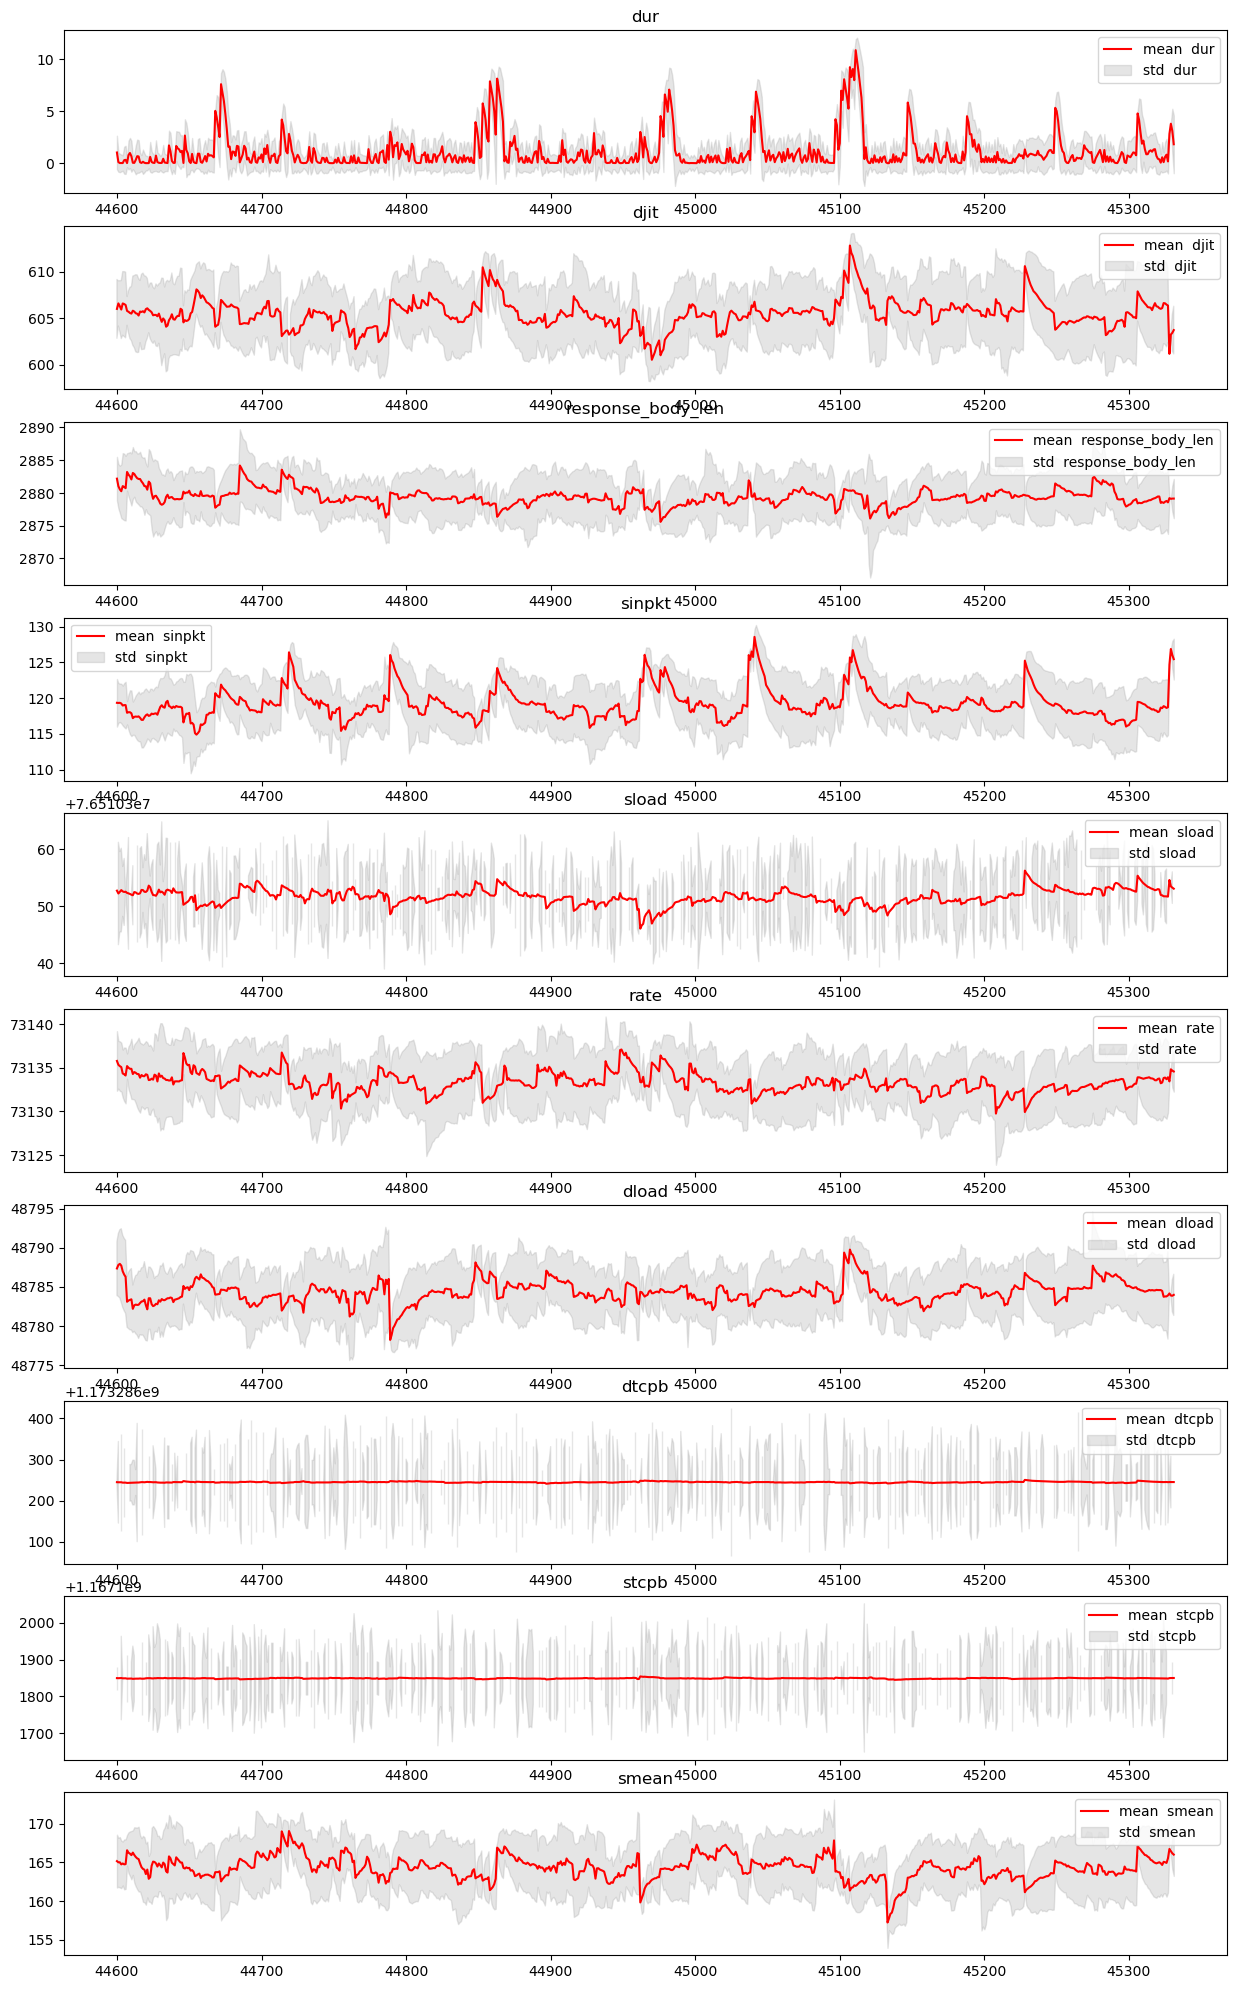

In [496]:
import numpy as np
import matplotlib.pyplot as plt
A_f = int(44600)
# Create a 5x2 grid of subplots
fig, axs = plt.subplots(A_amountofmeans, 1, figsize=(15, 25))
# Plot each of the 10 plots

k = 0
for i in range(A_amountofmeans):
        
        
        
#         # Plot the mean line and shaded region between upper and under lines
        axs[i].plot(A_t[A_f:], globals()[f"A_mean1_{k}"][A_f:], label=('mean  ' + features[k]), color='red')
        axs[i].fill_between(A_t[A_f:], globals()[f"A_under1_{k}"][A_f:], globals()[f"A_upper1_{k}"][A_f:], alpha=0.2, label=('std  ' + features[k]), color='grey')
        
#         axs[i].plot(A_t[A_f:], globals()[f"A_mean2_{k}"][A_f:], label=('mean  ' + features[k]), color='blue')
#         axs[i].fill_between(A_t[A_f:], globals()[f"A_under2_{k}"][A_f:], globals()[f"A_upper2_{k}"][A_f:], alpha=0.2, label=('std  ' + features[k]), color='grey')
        
#         axs[i].plot(A_t[A_f:], globals()[f"A_mean3_{k}"][A_f:], label=('mean  ' + features[k]), color='black')
#         axs[i].fill_between(A_t[A_f:], globals()[f"A_under3_{k}"][A_f:], globals()[f"A_upper3_{k}"][A_f:], alpha=0.2, label=('std  ' + features[k]), color='grey')
        
        
        
        # Set the title for the plot
        # axs[i].set_title(f'mean{k}')
        axs[i].set_title(features[k])

        
        # Set the legend for the plot
        axs[i].legend()
        
        
        k+=1

        
       
        
plt.show()
        

### NORMAL VS ANOMALY

compare the 2 distributions left right

In [497]:
min(N_under1_0)
np.nanmax(N_under1_8)
N_amountofmeans

10

#### Plotting side by side

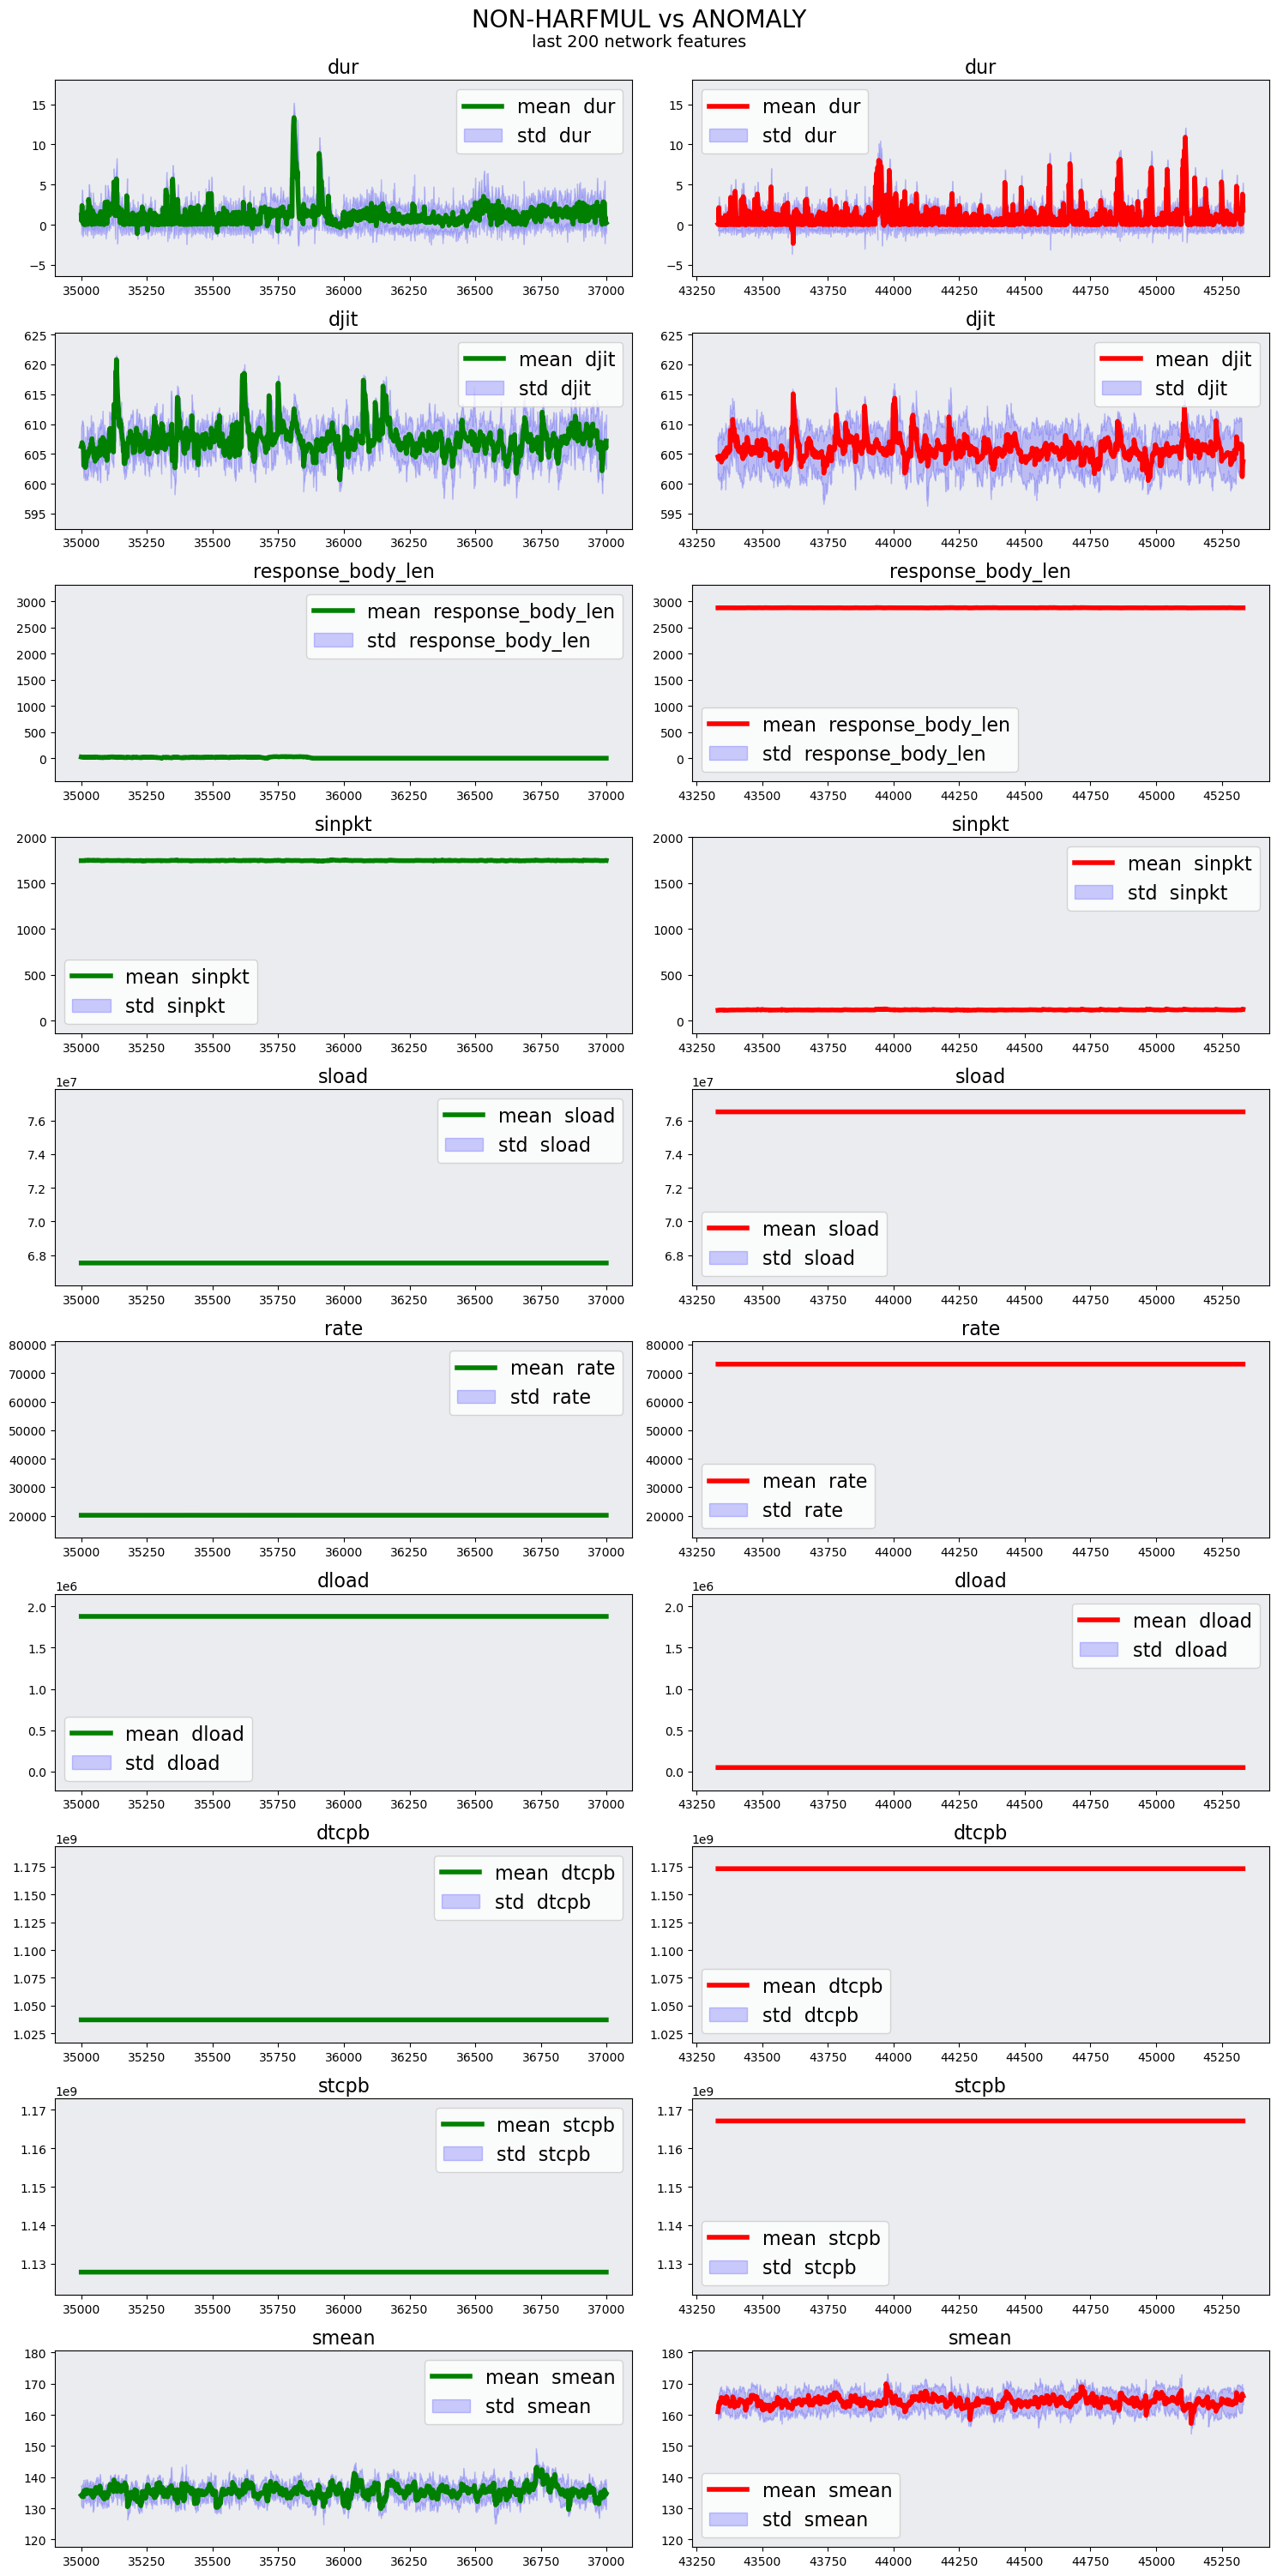

In [498]:
import numpy as np
import matplotlib.pyplot as plt
f = int(-2000)
A_f = f
# Create a 5x2 grid of subplots
# parameters = list(range(N_amountofmeans))
# parameters = [4, 7]
fig, axs = plt.subplots(N_amountofmeans, 2, figsize=(15, 30))
# Set the titles for the left and right columns
fig.suptitle('NON-HARFMUL vs ANOMALY', fontsize=20, y=1)
plt.figtext(0.5, 0.985, 'last 200 network features', fontsize=14, ha='center')
r = 0
linewidth = 4
ft = 16
col = "#EBECF0"
for i in range(N_amountofmeans):
        
        # Calculate the minimum of both under values and the maximum of both upper values
        # for the current subplot
        loc_min = min(min(globals()[f"N_under1_{i}"][f:]), min(globals()[f"A_under1_{i}"][A_f:]))
        loc_max = max(max(globals()[f"N_upper1_{i}"][f:]), max(globals()[f"A_upper1_{i}"][A_f:]))

        loc_min = min(np.nanmin(globals()[f"N_under1_{i}"][f:]), np.nanmin(globals()[f"A_under1_{i}"][A_f:]))
        loc_max = max(np.nanmax(globals()[f"N_upper1_{i}"][f:]), np.nanmax(globals()[f"A_upper1_{i}"][A_f:]))
        rangediff = loc_max-loc_min

        axs[r,0].plot(t[f:], globals()[f"N_mean1_{i}"][f:], label=('mean  ' + features[i]), color='green', linewidth=linewidth)
#         axs[r,0].plot(t[f:], globals()[f"N_mean1_{i}"][f:], label=('mean  ' + features[i]), color='green')
        axs[r,0].fill_between(t[f:], globals()[f"N_under1_{i}"][f:], globals()[f"N_upper1_{i}"][f:], alpha=0.2, label=('std  ' + features[i]), color='blue')
        axs[r,0].set_facecolor(col)
        
        axs[r,1].plot(A_t[A_f:], globals()[f"A_mean1_{i}"][A_f:], label=('mean  ' + features[i]), color='red',  linewidth=linewidth)
        axs[r,1].fill_between(A_t[A_f:], globals()[f"A_under1_{i}"][f:], globals()[f"A_upper1_{i}"][f:], alpha=0.2, label=('std  ' + features[i]), color='blue')
        axs[r,1].set_facecolor(col)
          
        
        
        # Set the y-axis limits for the current subplot
        axs[r,0].set_ylim(loc_min-0.15*rangediff, loc_max+0.15*rangediff)
        axs[r,1].set_ylim(loc_min-0.15*rangediff, loc_max+0.15*rangediff)
        
        
        
        # Set the title for the plot
        axs[r,0].set_title(features[i]).set_fontsize(ft)
        axs[r,1].set_title(features[i]).set_fontsize(ft)


        # Set the legend for the plot
        axs[r,0].legend(fontsize = ft)
        axs[r,1].legend(fontsize = ft)

        r+=1
        # Set the spacing between rows
fig.subplots_adjust(hspace=0.6)
# set spacing
fig.tight_layout()        
plt.savefig('statespacemodel', dpi = 300)       
        
plt.show()



In [499]:
import numpy as np
import matplotlib.pyplot as plt
f = int(-2000)
A_f = f

# Set the titles for the left and right columns
r = 0

gemiddelden = []
for i in range(N_amountofmeans):
        
        a = np.mean(globals()[f"N_mean1_{i}"][f:]- globals()[f"A_mean1_{i}"][f:])
        gemiddelden.append(a)

len(gemiddelden)

10

In [500]:
print(len(N_mean1_0[-10:]), len(A_mean1_0[-10:]))

10 10


In [501]:
import numpy as np
from scipy.stats import mannwhitneyu

f = 0
for j in [5]:
    
    for i in range(10):
        # Assuming you have two arrays representing the data of group 1 and group 2
        group1 = globals()[f"N_mean1_{i}"][-j:]
        group2 = globals()[f"A_mean1_{i}"][-j:]

        mean1 = np.mean(group1)
        mean2 = np.mean(group2)


        # Perform an independent t-test (two-sample t-test)
        t_statistic, p_value_ttest = ttest_ind(group1, group2)

        # Print the means and test results
        print("Group 1:", mean1)
        print("Group 2:", mean2)
        print()
        print("T-statistic:", t_statistic)
        print("P-value:", p_value_ttest)
        print()

        # Perform the Mann-Whitney U test
        MW_statistic, p_value_MW = mannwhitneyu(group1, group2, alternative='two-sided')

        # Print the test results
        
        print("U statistic:", statistic)
        print("P-value:", p_value)
        print()
        print()
        print()
        print()


Group 1: 0.3742043478389545
Group 2: 2.348760786458674

T-statistic: -3.0469008166073857
P-value: 0.015895704748177832

U statistic: -8.617274844321392
P-value: 6.856641447475644e-18




Group 1: 606.6263412384008
Group 2: 603.5910447504093

T-statistic: 3.5574751038962447
P-value: 0.0074280122641163715

U statistic: -8.617274844321392
P-value: 6.856641447475644e-18




Group 1: 0.19235436221895796
Group 2: 2879.0316083647945

T-statistic: -21091.0932904704
P-value: 2.8603900139853124e-32

U statistic: -8.617274844321392
P-value: 6.856641447475644e-18




Group 1: 1747.8446532342005
Group 2: 124.35511675474064

T-statistic: 1066.2490465360625
P-value: 6.704058177992e-22

U statistic: -8.617274844321392
P-value: 6.856641447475644e-18




Group 1: 67539761.01872453
Group 2: 76510353.2340184

T-statistic: -12296930.363728229
P-value: 2.1421225511106382e-54

U statistic: -8.617274844321392
P-value: 6.856641447475644e-18




Group 1: 20175.402230661068
Group 2: 73134.281877609

T-statistic:

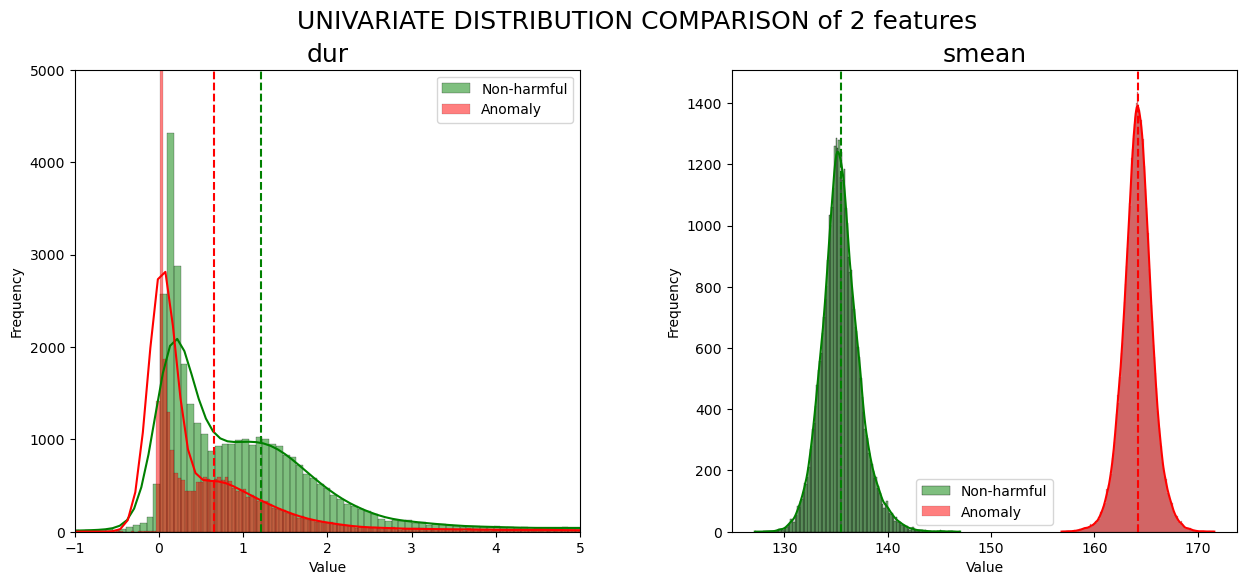

In [502]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ft = 18

# Generate example data for N_beta5 and A_beta5

# Create a figure with two subplots arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UNIVARIATE DISTRIBUTION COMPARISON of 2 features", fontsize =ft)
# fig.text("test")
# Plotting histograms and kernel density estimates for N_beta5
sns.histplot(N_mean1_0, kde=True, color='green', label='Non-harmful', ax=axs[0])
sns.histplot(A_mean1_0, kde=True, color='red', label='Anomaly', ax=axs[0])

axs[0].axvline(np.mean(N_mean1_0), color='green', linestyle='--')
axs[0].axvline(np.mean(A_mean1_0), color='red', linestyle='--')
axs[0].set_xlim(-1, 5)
axs[0].set_ylim(0, 5000)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title(features[0],fontsize = ft)
axs[0].legend()

# Plotting histograms and kernel density estimates for N_mean1_9
sns.histplot(N_mean1_9, kde=True, color='green', label='Non-harmful', ax=axs[1])
sns.histplot(A_mean1_9, kde=True, color='red', label='Anomaly', ax=axs[1])


axs[1].axvline(np.mean(N_mean1_9), color='green', linestyle='--')
axs[1].axvline(np.mean(A_mean1_9), color='red', linestyle='--')
# axs[1].set_xlim(-1, 5)
# axs[1].set_ylim(0, 5000)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title(features[9], fontsize = ft)
axs[1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.savefig("distribution comp", dpi=300)
# Show the plot
plt.show()


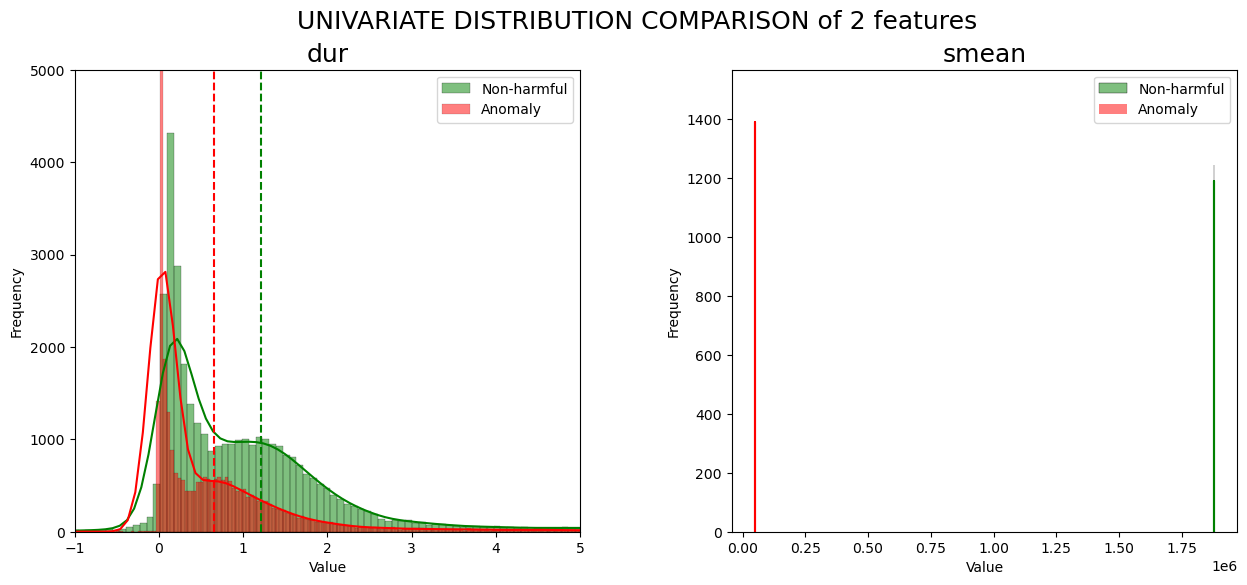

In [503]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ft = 18

# Generate example data for N_beta5 and A_beta5

# Create a figure with two subplots arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("UNIVARIATE DISTRIBUTION COMPARISON of 2 features", fontsize =ft)
# fig.text("test")
# Plotting histograms and kernel density estimates for N_beta5
sns.histplot(N_mean1_0, kde=True, color='green', label='Non-harmful', ax=axs[0])
sns.histplot(A_mean1_0, kde=True, color='red', label='Anomaly', ax=axs[0])

axs[0].axvline(np.mean(N_mean1_0), color='green', linestyle='--')
axs[0].axvline(np.mean(A_mean1_0), color='red', linestyle='--')
axs[0].set_xlim(-1, 5)
axs[0].set_ylim(0, 5000)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title(features[0],fontsize = ft)
axs[0].legend()

# Plotting histograms and kernel density estimates for N_mean1_9
sns.histplot(N_mean1_6, kde=True, color='green', label='Non-harmful', ax=axs[1])
sns.histplot(A_mean1_6, kde=True, color='red', label='Anomaly', ax=axs[1])


# axs[1].axvline(np.mean(A_mean1_6), color='green', linestyle='--')
# axs[1].axvline(np.mean(A_mean1_6), color='red', linestyle='--')
# axs[1].set_xlim(-1, 5)
# axs[1].set_ylim(0, 5000)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title(features[9], fontsize = ft)
axs[1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.savefig("distribution comp", dpi=300)
# Show the plot
plt.show()


## CHECKING THE MODEL

In [504]:
df_selected = dftot.loc[:,  features]
df_full = df_selected.to_numpy()
features


['dur',
 'djit',
 'response_body_len',
 'sinpkt',
 'sload',
 'rate',
 'dload',
 'dtcpb',
 'stcpb',
 'smean']

the last values

### **FUNCTION VISUAL** TO CREATE A CONFUSION MATRIX

In [505]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def CFM(dftot, Prediction):
    # Define the true labels and predicted labels
    true_labels = dftot['label']

    # Create the confusion matrix
    matrix = confusion_matrix(true_labels, Prediction)
    return matrix


In [506]:
#DEFINING A FUNCTION TO VISUALIZE 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(dftot, Prediction):
    # Define the true labels and predicted labels
    true_labels = dftot['label']

    # Create the confusion matrix
    matrix = confusion_matrix(true_labels, Prediction)

    # Calculate the percentages for each cell of the matrix
    percentages = np.round(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], 2)

    # Define the labels for the x and y axes
    
    labels = ['normal', 'anomaly']
    
    # Replace 0 and 1 with normal and anomaly in true_labels and Prediction
    true_labels = true_labels.replace({0:'normal', 1:'anomaly'})
    # Prediction = ['normal' if x==0 else 'anomaly' for x in Prediction]
    
    # Reshape the matrix and percentages into a 1D array for plotting
    matrix_flat = matrix.flatten()
    percentages_flat = percentages.flatten()

    # Define the color palette for the heatmap
    # colors = sns.color_palette('Blues', n_colors=100)
    colors = sns.color_palette("Spectral", as_cmap=True)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
#     sns.heatmap(matrix, fmt='', cmap='RdYlBu', cbar=False, ax=ax, xticklabels=labels, yticklabels=labels)
    sns.heatmap(matrix, fmt='', cmap="OrRd", cbar=False, ax=ax, xticklabels=labels, yticklabels=labels)
#
    #     ax = sns.heatmap(conf_mat, annot=True, cmap='RdYlBu', fmt='g', xticklabels=labels, yticklabels=labels, ax=axs[0])
    # Add the percentages as text to each cell of the heatmap
    for i, (matrix_value, percentage) in enumerate(zip(matrix_flat, percentages_flat)):
        ax.text(
            (i % 2) + 0.5, 
            (i // 2) + 0.5, 
            
            '{}\n({}%)'.format(matrix_value, percentage * 100), ha='center', va='center', c='white')

    # Add labels for the x and y axes
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('TRUE')

    # Add a title for the plot
    ax.set_title('Confusion Matrix' )

    # Show the plot
    plt.show()


CONFUSION MATRIX FOR NORMAL AND ANOMALY

In [507]:
# set the parameters

lag = 10
index = [5,6]
# calculate mean and var vectors
N_MEAN =[np.mean(N_mean1_0[-lag]), np.mean(N_mean1_1[-lag]), np.mean(N_mean1_2[-lag]),N_mean1_3[-lag],N_mean1_4[-lag],N_mean1_5[-lag],N_mean1_6[-lag],N_mean1_7[-lag],N_mean1_8[-lag],N_mean1_9[-lag]]
A_MEAN =[np.mean(A_mean1_0[-lag]) ,np.mean(A_mean1_1[-lag]),np.mean(A_mean1_2[-lag]),A_mean1_3[-lag],A_mean1_4[-lag],A_mean1_5[-lag],A_mean1_6[-lag],A_mean1_7[-lag],A_mean1_8[-lag],A_mean1_9[-lag]]

N_MEAN2 = np.array(N_MEAN)[index].tolist()
A_MEAN2 = np.array(A_MEAN)[index].tolist()


N_VAR =[np.mean(N_var1_0[-lag]), np.mean(N_var1_1[-lag]),np.mean(N_var1_2[-lag]),N_var1_3[-lag],N_var1_4[-lag],N_var1_5[-lag],N_var1_6[-lag],N_var1_7[-lag],N_var1_8[-lag],N_var1_9[-lag]]
A_VAR =[np.mean(A_var1_0[-lag]), np.mean(A_var1_1[-lag]) ,np.mean(A_var1_2[-lag]),A_var1_3[-lag],A_var1_4[-lag],A_var1_5[-lag],A_var1_6[-lag],A_var1_7[-lag],A_var1_8[-lag],A_var1_9[-lag]]

N_VAR2 = np.array(N_VAR)[index].tolist()
A_VAR2 = np.array(A_VAR)[index].tolist()

A_MEAN2
A_VAR2 


[4.789412498474121, 5.153440952301025]

**FUNCTION** PREDICT

In [508]:
len(df_full)

82332

In [509]:
import numpy as np
from scipy.stats import multivariate_normal

def predict(N_mean0, N_mean1, N_mean2, N_mean3, N_mean4, N_mean5, N_mean6, N_mean7, N_mean8, N_mean9,
            A_mean0, A_mean1, A_mean2, A_mean3, A_mean4, A_mean5, A_mean6, A_mean7, A_mean8, A_mean9,
            N_var0, N_var1, N_var2, N_var3, N_var4, N_var5, N_var6, N_var7, N_var8, N_var9,
            A_var0, A_var1, A_var2, A_var3, A_var4, A_var5, A_var6, A_var7, A_var8, A_var9, 
            index, lag, df_full):
      
    # calculate mean and var vectors
    ##### MEAN #####################
    
    N_MEAN = [np.mean(N_mean0[-lag]), np.mean(N_mean1[-lag]), np.mean(N_mean2[-lag]), N_mean3[-lag], 
              N_mean4[-lag], N_mean5[-lag], N_mean6[-lag], N_mean7[-lag], N_mean8[-lag], N_mean9[-lag]]
    A_MEAN = [np.mean(A_mean0[-lag]), np.mean(A_mean1[-lag]), np.mean(A_mean2[-lag]), A_mean3[-lag], 
              A_mean4[-lag], A_mean5[-lag], A_mean6[-lag], A_mean7[-lag], A_mean8[-lag], A_mean9[-lag]]

    N_MEAN2 = np.array(N_MEAN)[index].tolist()
    A_MEAN2 = np.array(A_MEAN)[index].tolist()
    
    ##### VAR #####################
    N_VAR = [np.mean(N_var0[-lag]), np.mean(N_var1[-lag]), np.mean(N_var2[-lag]), N_var3[-lag], 
             N_var4[-lag], N_var5[-lag], N_var6[-lag], N_var7[-lag], N_var8[-lag], N_var9[-lag]]
    A_VAR = [np.mean(A_var0[-lag]), np.mean(A_var1[-lag]), np.mean(A_var2[-lag]), A_var3[-lag], 
             A_var4[-lag], A_var5[-lag], A_var6[-lag], A_var7[-lag], A_var8[-lag], A_var9[-lag]]

    N_VAR2 = np.array(N_VAR)[index].tolist()
    A_VAR2 = np.array(A_VAR)[index].tolist()

    # create multivariate normal distribution object
#     N_mvn = multivariate_normal(mean=N_MEAN2, cov=np.diag(N_VAR2))
#     A_mvn = multivariate_normal(mean=A_MEAN2, cov=np.diag(A_VAR2))
    
    N_mvn = dists.MvNormal(loc=N_MEAN2, cov=np.diag(np.abs(N_VAR2)))
    A_mvn = dists.MvNormal(loc=A_MEAN2, cov=np.diag(np.abs(A_VAR2)))

    Ncount = 0
    Acount = 0
    Prediction = []
    for i in range(len(df_full)):
        x = df_full[i][index]

        N_likelihood = N_mvn.logpdf(x)
        A_likelihood = A_mvn.logpdf(x) 

        if (N_likelihood > A_likelihood):
            Ncount += 1
            Prediction.append(0)
        else:
            Acount += 1
            Prediction.append(1)

    return Prediction


### TESTING WITH CONFUSION AND PARAMETERS

In [510]:
index = [6]
lag = 1
a= dftot.shape[0]
# a = 70000
Prediction = predict(N_mean1_0, N_mean1_1, N_mean1_2, N_mean1_3, N_mean1_4, N_mean1_5, N_mean1_6, N_mean1_7, N_mean1_8, N_mean1_9,
            A_mean1_0, A_mean1_1, A_mean1_2, A_mean1_3, A_mean1_4, A_mean1_5, A_mean1_6, A_mean1_7, A_mean1_8, A_mean1_9,
            N_var1_0, N_var1_1, N_var1_2, N_var1_3, N_var1_4, N_var1_5, N_var1_6, N_var1_7, N_var1_8, N_var1_9,
            A_var1_0, A_var1_1, A_var1_2, A_var1_3, A_var1_4, A_var1_5, A_var1_6, A_var1_7, A_var1_8, A_var1_9, 
            index, lag, df_full)

# plot_confusion_matrix(dftot.tail(a), Prediction[-a:])

CF = CFM(dftot.tail(a), Prediction[-a:])

acc = (CF[0][0] + CF[1][1])/(CF[0][0] + CF[0][1]+CF[1][0] + CF[1][1]) 
prec = (CF[1][1])/(CF[1][0] + CF[1][1]) 
print(acc, prec)
print(CF, CF[0][0])

0.6116455327211777 0.9947719050560311
[[ 5263 31737]
 [  237 45095]] 5263


In [511]:
import itertools
from itertools import chain, combinations

lst = range(10)  #10 indexes to combine
combs = list(chain.from_iterable(combinations(lst, r) for r in range(1, 10)))
combs2 = [list(c) for c in combs]
combs3 = combs2[:98]
len(combs2)
combs3

len(combs3)
# combs2[0:174]
# list(enumerate(combs2))
combs4 = combs3[:55]
len(combs)

1022

In [512]:
lags = list(range(1, 11))
lags


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

SCRIPT UNDERNEATH IS COMMENTED : do not run /// timen!

In [513]:
best_accuracy = 0
best_precision = 0
combination = []
# DO NOT RUN BELOW
# for lag in lags:  #DO NOT RUN
for lag in [1]:   #temp run
    print("lag " + str(lag))
    #for index in enumerate(combs3): #DO NOT RUN
    for index in [[1]]: #temp run

#         ind = index[1]
        ind = index
        try:
            # call a function that might raise an error

            Prediction = predict(N_mean1_0, N_mean1_1, N_mean1_2, N_mean1_3, N_mean1_4, N_mean1_5, N_mean1_6, N_mean1_7, N_mean1_8, N_mean1_9,
                    A_mean1_0, A_mean1_1, A_mean1_2, A_mean1_3, A_mean1_4, A_mean1_5, A_mean1_6, A_mean1_7, A_mean1_8, A_mean1_9,
                    N_var1_0, N_var1_1, N_var1_2, N_var1_3, N_var1_4, N_var1_5, N_var1_6, N_var1_7, N_var1_8, N_var1_9,
                    A_var1_0, A_var1_1, A_var1_2, A_var1_3, A_var1_4, A_var1_5, A_var1_6, A_var1_7, A_var1_8, A_var1_9, 
                    ind, lag, df_full)




            # calculate confusion matrix
            confusion = confusion_matrix(dftot['label'], Prediction)

            # calculate accuracy score
            accuracy = (confusion[0][0] + confusion[1][1]) / np.sum(confusion)
            precision = (confusion[1][1]) / (confusion[1][0] +confusion[1][1])
            specificity = (confusion[0][0]) / (confusion[0][0] +confusion[0][1])
            print(str(ind))
            # check if current indices have highest accuracy so far
            if precision > best_precision:
                best_precision = precision
                best_indices_PR = ind
                print("new best precision at "+ str(ind) + " lag " + str(lag), precision)

            if accuracy > best_accuracy:
                if (precision > 0.55 and specificity > 0.4):
                    best_accuracy = accuracy
                    best_indices_AC = ind
                    print("new best accuracy at  "+ str(ind)+ " lag " + str(lag) + " " + str(best_accuracy), "precision: ", precision)
                    combination.append((lag, ind, precision, accuracy))

        
        except ValueError as e:
            # catch the error and continue the loop
#             print(f"Encountered an error: {e}")
            continue

lag 1
[1]
new best precision at [1] lag 1 0.00013235683402453013
